# Housing Price Prediction

A US based housing company is looking at prospective properties to buy to enter the market. You are required to build a regression model using regularisation in order to predict the actual value of the prospective properties and decide whether to invest in them or not.

The company wants to know:
1. Which variables are significant in predicting the price of a house, and
2. How well those variables describe the price of a house.

Also, determine the optimal value of lambda for ridge and lasso regression.

 1. Data Understanding and Exploration

In [1556]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import RFE

import os

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [1557]:
# reading the dataset
housing_raw = pd.read_csv("train.csv")

In [1558]:
housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [1559]:
housing_raw.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1560]:
# as per the data dictionary we have some categorical features with valid data as NA. eg No Garage and No Fireplace
# let us update those fileds so they dont get cleanued up as null field
valid_na_features = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'FireplaceQu' ,'Fence' ,'MiscFeature', 'PoolQC']
print(housing_raw[valid_na_features].isnull().sum())

Alley           1369
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
FireplaceQu      690
Fence           1179
MiscFeature     1406
PoolQC          1453
dtype: int64


In [1561]:
# Imputing NA values with "NOT_APP"
housing_raw[valid_na_features] = housing_raw[valid_na_features].fillna(value='NOT_APP', axis=1)
print(housing_raw[valid_na_features].isnull().sum())

Alley           0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
FireplaceQu     0
Fence           0
MiscFeature     0
PoolQC          0
dtype: int64


In [1562]:
#Now lets us look at the null/missing values
housing_raw.isnull().mean().sort_values(ascending=False)

MasVnrType     0.597260
LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
                 ...   
ExterCond      0.000000
ExterQual      0.000000
Exterior2nd    0.000000
Exterior1st    0.000000
SalePrice      0.000000
Length: 81, dtype: float64

In [1563]:
housing_raw.MasVnrType.value_counts()
#this is a cltegorical field 

MasVnrType
BrkFace    445
Stone      128
BrkCmn      15
Name: count, dtype: int64

In [1564]:
#lets look at LotFrontage data as it has the second highest fraction of null values
housing_raw['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

In [1565]:
#As the distribution of quartiles is between 59 and 80, 
#let's fill the null values in the Lotfrontage with the median value so that the distribution won't get impacted.
#   Do this after test train slip to avoid data leackage
#housing_raw['LotFrontage'].fillna(housing_raw['LotFrontage'].median(), inplace=True)

In [1566]:
housing_raw.isnull().mean().sort_values(ascending=False)

MasVnrType     0.597260
LotFrontage    0.177397
GarageYrBlt    0.055479
MasVnrArea     0.005479
Electrical     0.000685
                 ...   
ExterCond      0.000000
ExterQual      0.000000
Exterior2nd    0.000000
Exterior1st    0.000000
SalePrice      0.000000
Length: 81, dtype: float64

In [1567]:
#Now lets look for columns where the unique value count is low. 
#Which means that column cannot be a good preictor of target variable.
housing_raw.nunique().sort_values(ascending=False)

Id            1460
LotArea       1073
GrLivArea      861
BsmtUnfSF      780
1stFlrSF       753
              ... 
HalfBath         3
LandSlope        3
CentralAir       2
Utilities        2
Street           2
Length: 81, dtype: int64

In [1568]:
# find columns that have 90% same data. little variance may not help with the analysis
columns_same_value = []

for column in housing_raw.columns:
    # Count occurrences of the most frequent value
    most_frequent_count = housing_raw[column].value_counts().max()
    
    # Calculate percentage
    percentage = most_frequent_count / len(housing_raw)
    
    # Check if the percentage is >= 90%
    if percentage >= 0.90:
        columns_same_value.append(column)
        print(column,percentage)

Street 0.9958904109589041
Alley 0.9376712328767123
Utilities 0.9993150684931507
LandSlope 0.9465753424657535
Condition2 0.9897260273972602
RoofMatl 0.9821917808219178
Heating 0.9780821917808219
CentralAir 0.934931506849315
Electrical 0.9136986301369863
LowQualFinSF 0.9821917808219178
BsmtHalfBath 0.9438356164383561
KitchenAbvGr 0.9534246575342465
Functional 0.9315068493150684
GarageCond 0.9082191780821918
PavedDrive 0.9178082191780822
3SsnPorch 0.9835616438356164
ScreenPorch 0.9205479452054794
PoolArea 0.9952054794520548
PoolQC 0.9952054794520548
MiscFeature 0.963013698630137
MiscVal 0.9643835616438357


In [1569]:
#drop colums with more than 90% same values
housing_raw.drop(columns=columns_same_value, inplace=True)

In [1570]:
#drop Id field as it is just a identifier and will have no impact on analysis
housing_raw.drop(columns=['Id'], inplace=True)

In [1571]:
housing_raw.shape

(1460, 59)

In [1572]:
#Now we can check for the null values row wise
null_rws = housing_raw.isnull().sum().sort_values(ascending=False)
null_rws.head(20)

MasVnrType      872
LotFrontage     259
GarageYrBlt      81
MasVnrArea        8
GarageType        0
1stFlrSF          0
2ndFlrSF          0
GrLivArea         0
BsmtFullBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenQual       0
TotRmsAbvGrd      0
Fireplaces        0
FireplaceQu       0
MSSubClass        0
TotalBsmtSF       0
GarageFinish      0
GarageCars        0
dtype: int64

In [1573]:
#drop MasVnrType as it has very high empty values
housing_raw.drop(columns=['MasVnrType'], inplace=True)

In [1574]:
housing_raw.shape

(1460, 58)

In [1575]:
housing_raw.isnull().sum().sort_values(ascending=False)

LotFrontage      259
GarageYrBlt       81
MasVnrArea         8
GarageType         0
1stFlrSF           0
2ndFlrSF           0
GrLivArea          0
BsmtFullBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenQual        0
TotRmsAbvGrd       0
Fireplaces         0
FireplaceQu        0
MSSubClass         0
TotalBsmtSF        0
GarageFinish       0
GarageCars         0
GarageArea         0
GarageQual         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
Fence              0
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
HeatingQC          0
BsmtUnfSF          0
MSZoning           0
YearRemodAdd       0
LotArea            0
LotShape           0
LandContour        0
LotConfig          0
Neighborhood       0
Condition1         0
BldgType           0
HouseStyle         0
OverallQual        0
OverallCond        0
YearBuilt          0
RoofStyle          0
BsmtFinSF2         0
Exterior1st        0
Exterior2nd  

In [1576]:
#let us look at the target variable
housing_raw.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

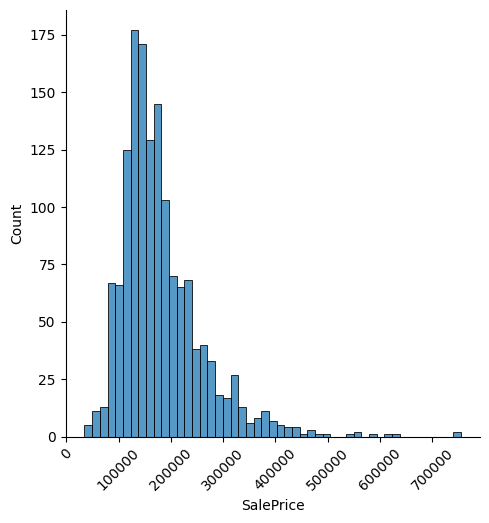

In [1577]:
# target variable: price of car
sns.displot(housing_raw.SalePrice)
plt.xticks(rotation=45)
plt.show()

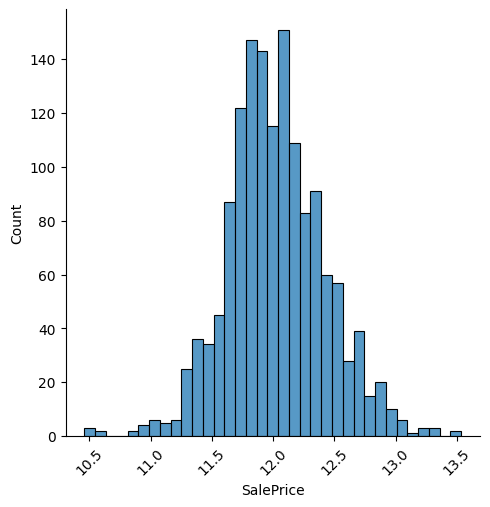

In [1578]:
# target variable: is skewed lets check the log values
sns.displot(np.log((housing_raw.SalePrice)))
plt.xticks(rotation=45)
plt.show()
#now we see a normal distribution

In [1579]:
#update the target variable with its log values
housing_raw.SalePrice = np.log(housing_raw.SalePrice)

In [1580]:
# Converting the year related features into number of years

for feature in ['GarageYrBlt','YearBuilt','YearRemodAdd', 'YrSold']:
    housing_raw[feature] = 2023 - housing_raw[feature]

2. Data Exploration

In [1581]:
# all numeric (float and int) variables in the dataset
housing_numeric = housing_raw.select_dtypes(include=['float64', 'int64'])
housing_numeric.head()

#some numeric data are categorical but are Ordinal. So we can still see correlation trends

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,20,20,196.0,706,0,...,0,20.0,2,548,0,61,0,2,15,12.247694
1,20,80.0,9600,6,8,47,47,0.0,978,0,...,1,47.0,2,460,298,0,0,5,16,12.109011
2,60,68.0,11250,7,5,22,21,162.0,486,0,...,1,22.0,2,608,0,42,0,9,15,12.317167
3,70,60.0,9550,7,5,108,53,0.0,216,0,...,1,25.0,3,642,0,35,272,2,17,11.849398
4,60,84.0,14260,8,5,23,23,350.0,655,0,...,1,23.0,3,836,192,84,0,12,15,12.429216


In [1582]:
housing_numeric.shape

(1460, 30)

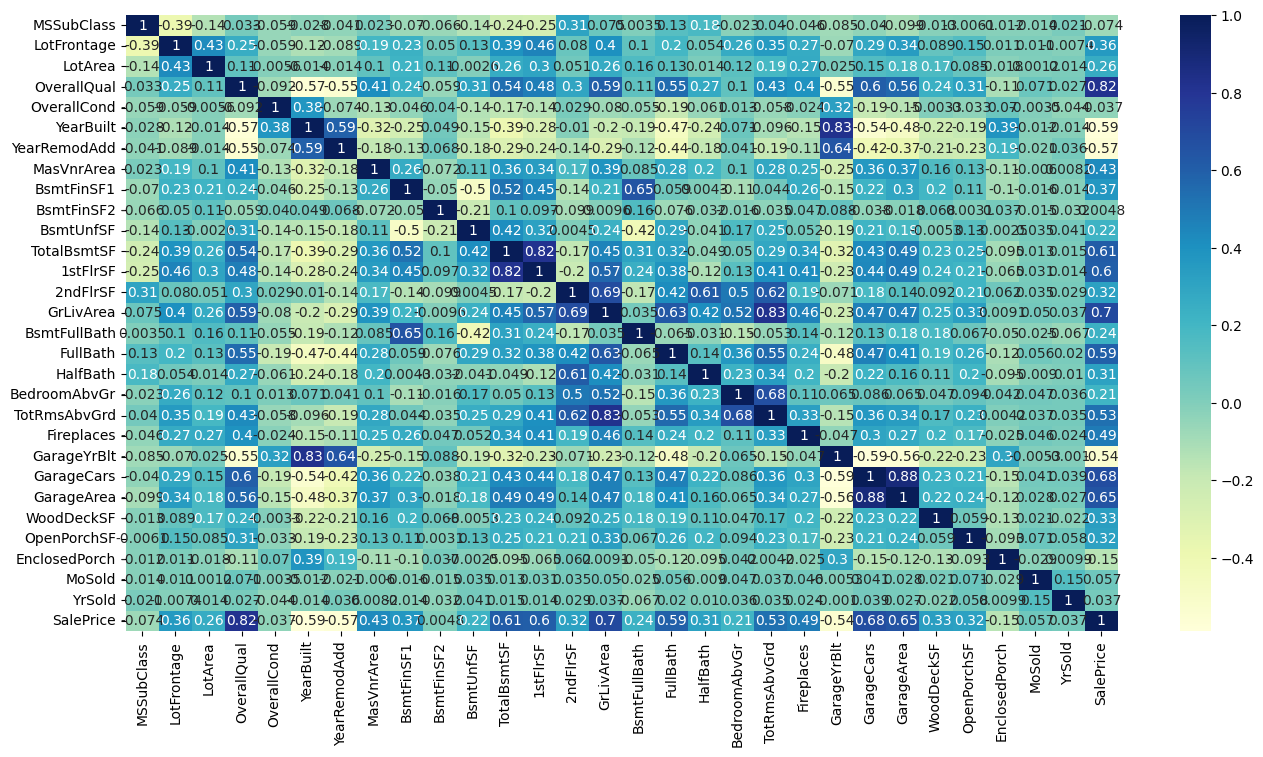

In [1583]:
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(housing_numeric.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [1584]:

# The matrix is too cluttred. Only keep correlations greater than 0.6 and less than -0.6
correlation_matrix = housing_numeric.corr()
high_correlation = correlation_matrix[abs(correlation_matrix) > 0.6]


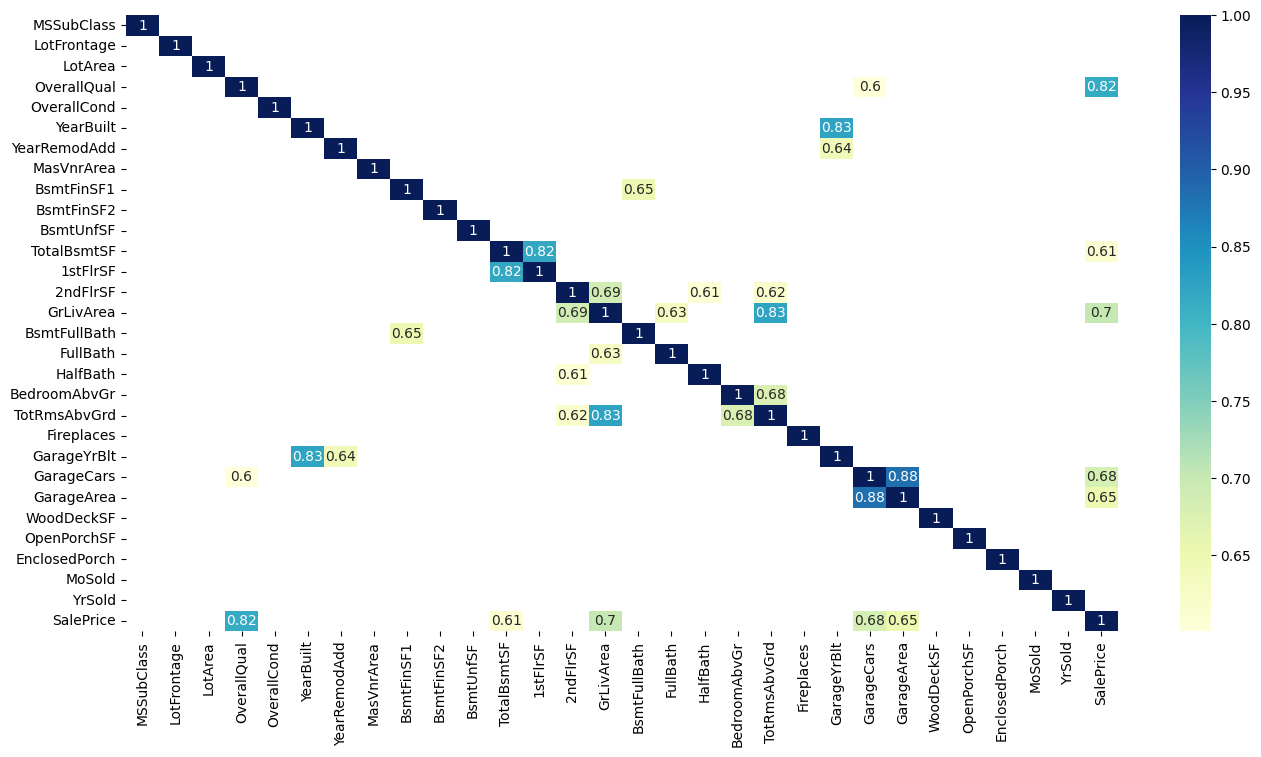

In [1585]:
# plotting high correlations on a heatmap

# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(high_correlation, cmap="YlGnBu", annot=True)
plt.show()

Sale Price has a high positive correlation with:
1. OverAllQual - overall material and finish of the house
2. TotalBsmtSF - Drop, as it has high corelation with 1stFlrSF 
3. 1stFlrSF - 
4. GrLivArea - Drop, as this is obviously highly corelated with 1stFlrSF
5. GarageCars - Drop, this is obviously highly corelated with GarageArea
6. GarageArea

We also observe high correleation between the following independent varibles. These are on expected lines:
1. GarageYrBuit and YearBuilt  - Drop GarageYrBuit
2. BsmtFullBath with BsmtFinSF1 - type 1 finished Sq Ft probably includes bath in Basement
3. 2ndFlrSf with  TotRmsAbvGrd, HalfBath, GrLivArea
4. GrLivArea with TotRmsAbvGrd - Drop GrLivArea as more area would correlate to more rooms
5. BedRmsAbvGr with TotRmsAbvGr

In [1586]:
housing_raw.drop(['GarageCars', 'GarageYrBlt', 'GrLivArea', 'TotalBsmtSF'], axis=1, inplace=True)


3. Data Preparation

In [1587]:
housing_raw.dtypes.value_counts()

object     28
int64      23
float64     3
Name: count, dtype: int64

Encoding ordered features

In [1588]:
housing_raw['LotShape'] = housing_raw['LotShape'].map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})
housing_raw['HouseStyle'] = housing_raw['HouseStyle'].map({'1Story':0, '1.5Unf':1, '1.5Fin':2,  '2Story' :3, '2.5Unf':4, '2.5Fin':5, 'SFoyer':6, 'SLvl':7})
housing_raw['ExterQual'] = housing_raw['ExterQual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_raw['ExterCond'] = housing_raw['ExterCond'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_raw['BsmtQual'] = housing_raw['BsmtQual'].map({'NOT_APP':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_raw['BsmtCond'] = housing_raw['BsmtCond'].map({'NOT_APP':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_raw['BsmtExposure'] = housing_raw['BsmtExposure'].map({'NOT_APP':0,'No':1,'Mn':2,'Av':3,'Gd':4})
housing_raw['BsmtFinType1'] = housing_raw['BsmtFinType1'].map({'NOT_APP':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housing_raw['BsmtFinType2'] = housing_raw['BsmtFinType2'].map({'NOT_APP':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
housing_raw['HeatingQC'] = housing_raw['HeatingQC'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_raw['KitchenQual'] = housing_raw['KitchenQual'].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
housing_raw['GarageFinish'] = housing_raw['GarageFinish'].map({'NOT_APP':0,'Unf':1,'RFn':2,'Fin':3})
housing_raw['GarageQual'] = housing_raw['GarageQual'].map({'NOT_APP':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
housing_raw['FireplaceQu'] = housing_raw['FireplaceQu'].map({'NOT_APP':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

In [1589]:
housing_raw[['LotShape', 'HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual','FireplaceQu', 'GarageFinish', 'GarageQual']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   LotShape      1460 non-null   int64
 1   HouseStyle    1460 non-null   int64
 2   ExterQual     1460 non-null   int64
 3   ExterCond     1460 non-null   int64
 4   BsmtQual      1460 non-null   int64
 5   BsmtCond      1460 non-null   int64
 6   BsmtExposure  1460 non-null   int64
 7   BsmtFinType1  1460 non-null   int64
 8   BsmtFinType2  1460 non-null   int64
 9   HeatingQC     1460 non-null   int64
 10  KitchenQual   1460 non-null   int64
 11  FireplaceQu   1460 non-null   int64
 12  GarageFinish  1460 non-null   int64
 13  GarageQual    1460 non-null   int64
dtypes: int64(14)
memory usage: 159.8 KB


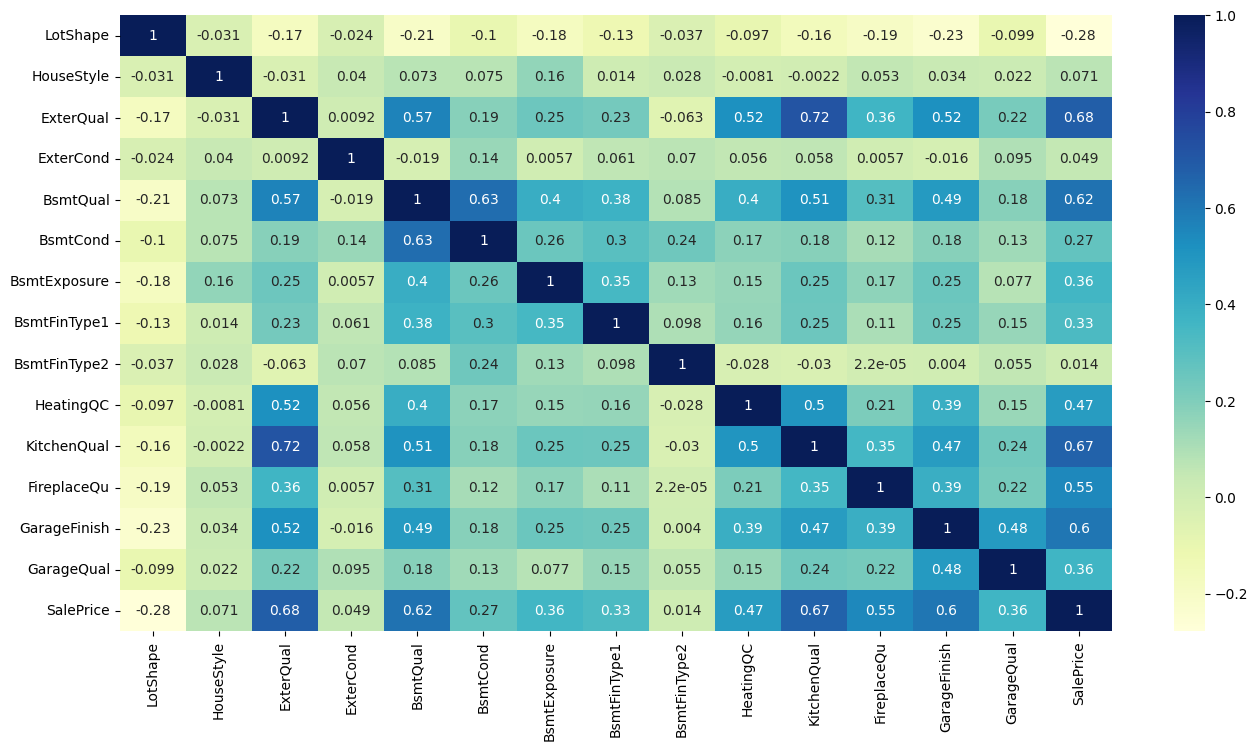

In [1590]:
#lets look at correlations with ordered featured now that they have been encoded
housing_ordered = housing_raw[['LotShape', 'HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual','FireplaceQu', 'GarageFinish', 'GarageQual', 'SalePrice']]

# plotting correlations on a heatmap
# figure size
plt.figure(figsize=(16,8))

# heatmap
sns.heatmap(housing_ordered.corr(), cmap="YlGnBu", annot=True)
plt.show()

Target variable has high correlation with 

1. ExterQual
2. BsmtQual
3. KitchenQual
4. GarageFinish

It also shows a negative correlation with LotShape. Looks like some irregular plots have a high Sale Price

Independent features with high correlations:
1. KitchenQual and ExterQual - Drop KitchenQual
2. BsmtCond and BsmtQual - drop BsmtCond

In [1591]:
housing_ordered.drop(columns=['KitchenQual', 'BsmtCond', 'SalePrice'],  inplace=True)

In [1592]:
housing_raw.drop(columns=['LotShape', 'HouseStyle', 'ExterQual', 'ExterCond', 'BsmtQual', 
                          'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 
                          'KitchenQual','FireplaceQu', 'GarageFinish', 'GarageQual'], inplace=True)

In [1593]:
housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 40 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LandContour    1460 non-null   object 
 5   LotConfig      1460 non-null   object 
 6   Neighborhood   1460 non-null   object 
 7   Condition1     1460 non-null   object 
 8   BldgType       1460 non-null   object 
 9   OverallQual    1460 non-null   int64  
 10  OverallCond    1460 non-null   int64  
 11  YearBuilt      1460 non-null   int64  
 12  YearRemodAdd   1460 non-null   int64  
 13  RoofStyle      1460 non-null   object 
 14  Exterior1st    1460 non-null   object 
 15  Exterior2nd    1460 non-null   object 
 16  MasVnrArea     1452 non-null   float64
 17  Foundation     1460 non-null   object 
 18  BsmtFinS

In [1594]:
housing_raw = pd.concat([housing_raw, housing_ordered], axis=1)


In [1595]:
housing_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 52 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   LandContour    1460 non-null   object 
 5   LotConfig      1460 non-null   object 
 6   Neighborhood   1460 non-null   object 
 7   Condition1     1460 non-null   object 
 8   BldgType       1460 non-null   object 
 9   OverallQual    1460 non-null   int64  
 10  OverallCond    1460 non-null   int64  
 11  YearBuilt      1460 non-null   int64  
 12  YearRemodAdd   1460 non-null   int64  
 13  RoofStyle      1460 non-null   object 
 14  Exterior1st    1460 non-null   object 
 15  Exterior2nd    1460 non-null   object 
 16  MasVnrArea     1452 non-null   float64
 17  Foundation     1460 non-null   object 
 18  BsmtFinS

Nominal Categorical Features

In [1596]:
# Get object-type columns
object_cols = housing_raw.select_dtypes(include=['object'])
object_cols

,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,BldgType,RoofStyle,Exterior1st,Exterior2nd,Foundation,GarageType,Fence,SaleType,SaleCondition
0,RL,Lvl,Inside,CollgCr,Norm,1Fam,Gable,VinylSd,VinylSd,PConc,Attchd,NOT_APP,WD,Normal
1,RL,Lvl,FR2,Veenker,Feedr,1Fam,Gable,MetalSd,MetalSd,CBlock,Attchd,NOT_APP,WD,Normal
2,RL,Lvl,Inside,CollgCr,Norm,1Fam,Gable,VinylSd,VinylSd,PConc,Attchd,NOT_APP,WD,Normal
3,RL,Lvl,Corner,Crawfor,Norm,1Fam,Gable,Wd Sdng,Wd Shng,BrkTil,Detchd,NOT_APP,WD,Abnorml
4,RL,Lvl,FR2,NoRidge,Norm,1Fam,Gable,VinylSd,VinylSd,PConc,Attchd,NOT_APP,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Lvl,Inside,Gilbert,Norm,1Fam,Gable,VinylSd,VinylSd,PConc,Attchd,NOT_APP,WD,Normal
1456,RL,Lvl,Inside,NWAmes,Norm,1Fam,Gable,Plywood,Plywood,CBlock,Attchd,MnPrv,WD,Normal
1457,RL,Lvl,Inside,Crawfor,Norm,1Fam,Gable,CemntBd,CmentBd,Stone,Attchd,GdPrv,WD,Normal
1458,RL,Lvl,Inside,NAmes,Norm,1Fam,Hip,MetalSd,MetalSd,CBlock,Attchd,NOT_APP,WD,Normal


In [1597]:
# Create dummy variables for object-type columns
dummy_cols = pd.get_dummies(object_cols, drop_first=True)  # drop_first=True to avoid dummy variable trap
dummy_cols = dummy_cols.astype(int)
dummy_cols


,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,0,0,1,0,1,0,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1456,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1457,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1458,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [1598]:
# find columns that have 90% same data. little variance may not help with the analysis
columns_same_value = []

for column in dummy_cols.columns:
    # Count occurrences of the most frequent value
    most_frequent_count = dummy_cols[column].value_counts().max()
    
    # Calculate percentage
    percentage = most_frequent_count / len(housing_raw)
    
    # Check if the percentage is >= 90%
    if percentage >= 0.90:
        columns_same_value.append(column)
        print(column,percentage)

MSZoning_FV 0.9554794520547946
MSZoning_RH 0.989041095890411
LandContour_HLS 0.9657534246575342
LandContour_Low 0.9753424657534246
LotConfig_CulDSac 0.9356164383561644
LotConfig_FR2 0.9678082191780822
LotConfig_FR3 0.9972602739726028
Neighborhood_Blueste 0.9986301369863013
Neighborhood_BrDale 0.989041095890411
Neighborhood_BrkSide 0.9602739726027397
Neighborhood_ClearCr 0.9808219178082191
Neighborhood_Crawfor 0.9650684931506849
Neighborhood_Edwards 0.9315068493150684
Neighborhood_Gilbert 0.9458904109589041
Neighborhood_IDOTRR 0.9746575342465753
Neighborhood_MeadowV 0.9883561643835617
Neighborhood_Mitchel 0.9664383561643836
Neighborhood_NPkVill 0.9938356164383562
Neighborhood_NWAmes 0.95
Neighborhood_NoRidge 0.9719178082191781
Neighborhood_NridgHt 0.9472602739726027
Neighborhood_OldTown 0.9226027397260274
Neighborhood_SWISU 0.9828767123287672
Neighborhood_Sawyer 0.9493150684931507
Neighborhood_SawyerW 0.9595890410958904
Neighborhood_Somerst 0.9410958904109589
Neighborhood_StoneBr 0.9828

In [1599]:
len(columns_same_value)
# we have 84 columns with more than 90% same values. we need to drop them

84

In [1600]:
dummy_cols.drop(columns=columns_same_value, inplace=True)

In [1601]:
housing_raw.shape

(1460, 52)

In [1602]:
dummy_cols.shape

(1460, 25)

In [1603]:
# Concatenate dummy variables with the original DataFrame
housing_numeric = housing_raw.drop(object_cols.columns, axis=1)
housing_with_dummies = pd.concat([housing_numeric, dummy_cols], axis=1)
housing_with_dummies


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_Detchd,Fence_MnPrv,Fence_NOT_APP,SaleType_WD,SaleCondition_Normal
0,60,65.0,8450,7,5,20,20,196.0,706,0,...,1,0,0,1,1,0,0,1,1,1
1,20,80.0,9600,6,8,47,47,0.0,978,0,...,0,0,1,0,1,0,0,1,1,1
2,60,68.0,11250,7,5,22,21,162.0,486,0,...,1,0,0,1,1,0,0,1,1,1
3,70,60.0,9550,7,5,108,53,0.0,216,0,...,0,0,0,0,0,1,0,1,1,0
4,60,84.0,14260,8,5,23,23,350.0,655,0,...,1,0,0,1,1,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,24,23,0.0,0,0,...,1,0,0,1,1,0,0,1,1,1
1456,20,85.0,13175,6,6,45,35,119.0,790,163,...,0,0,1,0,1,0,1,0,1,1
1457,70,66.0,9042,7,9,82,17,0.0,275,0,...,0,0,0,0,1,0,0,0,1,1
1458,20,68.0,9717,5,6,73,27,0.0,49,1029,...,0,0,1,0,1,0,0,1,1,1


In [1604]:
housing_with_dummies.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_Detchd,Fence_MnPrv,Fence_NOT_APP,SaleType_WD,SaleCondition_Normal
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,51.732192,38.134247,103.685262,443.639726,46.549315,...,0.345205,0.134932,0.434247,0.443151,0.595890,0.265068,0.107534,0.807534,0.867808,0.820548
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,...,0.475598,0.341767,0.495827,0.496928,0.490887,0.441521,0.309897,0.394372,0.338815,0.383862
min,20.000000,21.000000,1300.000000,1.000000,1.000000,13.000000,13.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,23.000000,19.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,50.000000,29.000000,0.000000,383.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,69.000000,56.000000,166.000000,712.250000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,151.000000,73.000000,1600.000000,5644.000000,1474.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1605]:
housing_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 63 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   MSSubClass            1460 non-null   int64  
 1   LotFrontage           1201 non-null   float64
 2   LotArea               1460 non-null   int64  
 3   OverallQual           1460 non-null   int64  
 4   OverallCond           1460 non-null   int64  
 5   YearBuilt             1460 non-null   int64  
 6   YearRemodAdd          1460 non-null   int64  
 7   MasVnrArea            1452 non-null   float64
 8   BsmtFinSF1            1460 non-null   int64  
 9   BsmtFinSF2            1460 non-null   int64  
 10  BsmtUnfSF             1460 non-null   int64  
 11  1stFlrSF              1460 non-null   int64  
 12  2ndFlrSF              1460 non-null   int64  
 13  BsmtFullBath          1460 non-null   int64  
 14  FullBath              1460 non-null   int64  
 15  HalfBath             

Split into test and train sets

In [1606]:

np.random.seed(0)
df_train, df_test = train_test_split(housing_with_dummies, train_size = 0.7, test_size = 0.3, random_state = 100)
df_test.shape

(438, 63)

In [1607]:
df_train.shape

(1021, 63)

In [1608]:
# Imputing missing value of LotFrontage after splitting training and test set to prevent data leakage.
df_train['LotFrontage'].fillna(df_train['LotFrontage'].median(), inplace=True)
#drop the remaining nan rows as now we have a small set 
df_train.dropna(inplace=True)
print(df_train.isnull().sum().sort_values(ascending=False))

MSSubClass              0
Exterior1st_HdBoard     0
HeatingQC               0
FireplaceQu             0
GarageFinish            0
                       ..
LotShape                0
HouseStyle              0
ExterQual               0
ExterCond               0
SaleCondition_Normal    0
Length: 63, dtype: int64


In [1609]:
# Imputing missing value of LotFrontage after splitting training and test set to prevent data leakage.
df_test['LotFrontage'].fillna(df_test['LotFrontage'].median(), inplace=True)
#drop the remaining nan rows as now we have a small set 
df_test.dropna(inplace=True)
print(df_train.isnull().sum().sort_values(ascending=False))

MSSubClass              0
Exterior1st_HdBoard     0
HeatingQC               0
FireplaceQu             0
GarageFinish            0
                       ..
LotShape                0
HouseStyle              0
ExterQual               0
ExterCond               0
SaleCondition_Normal    0
Length: 63, dtype: int64


Scaling the train set - fit and tramsform

In [1610]:

scaler = MinMaxScaler()

In [1611]:
# select columns where it is relevant to apply scaler
cols_to_scale = housing_numeric.columns
df_train[cols_to_scale] = scaler.fit_transform(df_train[cols_to_scale])
df_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_Detchd,Fence_MnPrv,Fence_NOT_APP,SaleType_WD,SaleCondition_Normal
210,0.058824,0.157534,0.019306,0.444444,0.625,0.615942,1.000000,0.00,0.082920,0.0,...,0,0,1,0,0,0,0,1,1,1
318,0.235294,0.236301,0.039403,0.666667,0.500,0.123188,0.283333,0.16,0.174876,0.0,...,0,0,0,1,1,0,0,1,1,1
239,0.176471,0.106164,0.033981,0.555556,0.375,0.471014,1.000000,0.00,0.016655,0.0,...,1,0,1,0,0,1,1,0,1,1
986,0.176471,0.130137,0.017931,0.555556,0.875,0.724638,0.116667,0.00,0.000000,0.0,...,1,0,1,0,1,0,0,1,1,1
1416,1.000000,0.133562,0.046139,0.333333,0.625,0.905797,1.000000,0.00,0.000000,0.0,...,0,0,0,1,0,1,0,1,1,1


In [1612]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_Detchd,Fence_MnPrv,Fence_NOT_APP,SaleType_WD,SaleCondition_Normal
count,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,...,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000,1017.000000
mean,0.226792,0.165454,0.042136,0.565061,0.573009,0.281732,0.418994,0.065563,0.079154,0.034114,...,0.331367,0.131760,0.431662,0.449361,0.588004,0.270403,0.105211,0.818092,0.872173,0.826942
std,0.254959,0.075630,0.048316,0.155172,0.136698,0.219806,0.343884,0.117247,0.082302,0.116116,...,0.470936,0.338396,0.495552,0.497674,0.492437,0.444387,0.306977,0.385958,0.334061,0.378484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.133562,0.027885,0.444444,0.500000,0.072464,0.116667,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.176471,0.160959,0.037494,0.555556,0.500000,0.268116,0.266667,0.000000,0.069100,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.294118,0.195205,0.046887,0.666667,0.625000,0.405797,0.716667,0.098750,0.125443,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1613]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [1614]:
y_train

210     0.335850
318     0.653235
239     0.382177
986     0.393493
1416    0.408435
          ...   
1009    0.348863
802     0.549490
53      0.780929
350     0.718800
79      0.373425
Name: SalePrice, Length: 1017, dtype: float64

In [1615]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_Detchd,Fence_MnPrv,Fence_NOT_APP,SaleType_WD,SaleCondition_Normal
210,0.058824,0.157534,0.019306,0.444444,0.625,0.615942,1.000000,0.00000,0.082920,0.0,...,0,0,1,0,0,0,0,1,1,1
318,0.235294,0.236301,0.039403,0.666667,0.500,0.123188,0.283333,0.16000,0.174876,0.0,...,0,0,0,1,1,0,0,1,1,1
239,0.176471,0.106164,0.033981,0.555556,0.375,0.471014,1.000000,0.00000,0.016655,0.0,...,1,0,1,0,0,1,1,0,1,1
986,0.176471,0.130137,0.017931,0.555556,0.875,0.724638,0.116667,0.00000,0.000000,0.0,...,1,0,1,0,1,0,0,1,1,1
1416,1.000000,0.133562,0.046139,0.333333,0.625,0.905797,1.000000,0.00000,0.000000,0.0,...,0,0,0,1,0,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1009,0.176471,0.133562,0.021158,0.444444,0.500,0.608696,1.000000,0.00000,0.000000,0.0,...,0,1,0,0,0,0,0,1,1,1
802,0.235294,0.143836,0.031445,0.666667,0.500,0.036232,0.083333,0.00000,0.114812,0.0,...,0,0,0,1,1,0,0,1,1,1
53,0.000000,0.160959,0.228257,0.888889,0.500,0.210145,0.383333,0.00000,0.320695,0.0,...,0,0,1,0,1,0,0,1,1,1
350,0.588235,0.160959,0.029672,0.888889,0.500,0.021739,0.050000,0.22625,0.000000,0.0,...,0,0,0,1,1,0,0,1,0,0


4. Model Building and Evaluation

Linear Regression

In [1616]:
# Instantiate
lm = LinearRegression()

# Fit a line
lm.fit(X_train, y_train)
# Print the coefficients and intercept
print(lm.intercept_)
print(lm.coef_)

0.07304151801241743
[-0.03558329 -0.05668745  0.12770208  0.21452101  0.11625712 -0.05586511
 -0.01784968  0.01840499 -0.10181769  0.0110718  -0.02083996  0.30222046
  0.10991334  0.05853     0.03955825  0.01816032  0.04308616  0.04779556
  0.00334807  0.09251317  0.0186221  -0.00519998  0.01670252  0.00043456
  0.00997739 -0.0028397  -0.01581016  0.00966889 -0.01426272  0.04500231
  0.03075121  0.02806432 -0.01830831  0.01854369  0.03329802  0.01020497
 -0.00063372  0.00704558 -0.01629089  0.00481989 -0.0029789  -0.01362701
  0.00328915  0.0220628  -0.02351757 -0.02050163 -0.00999886 -0.01387316
  0.00765217 -0.01420078  0.00687412  0.0218576  -0.0033323   0.01117103
  0.00729062  0.01629139  0.01424481  0.00566456  0.01047389  0.01094805
 -0.00891216  0.01134354]


Scaling to the test set  - only transform

In [1617]:
df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale])

In [1618]:
df_test.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,GarageType_Detchd,Fence_MnPrv,Fence_NOT_APP,SaleType_WD,SaleCondition_Normal
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,...,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,0.195175,0.170657,0.042502,0.567588,0.571141,0.282258,0.424194,0.063173,0.076154,0.026298,...,0.373272,0.145161,0.449309,0.417051,0.608295,0.258065,0.115207,0.778802,0.861751,0.811060
std,0.233746,0.075123,0.042897,0.149692,0.144973,0.216742,0.345592,0.103180,0.076812,0.093055,...,0.484232,0.352670,0.497998,0.493640,0.488695,0.438075,0.319641,0.415533,0.345559,0.391913
min,0.000000,0.000000,-0.000828,0.000000,0.125000,0.007246,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.133562,0.029354,0.444444,0.500000,0.072464,0.100000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,0.176471,0.167808,0.037005,0.555556,0.500000,0.275362,0.291667,0.000000,0.063164,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000
75%,0.235294,0.202055,0.047823,0.666667,0.625000,0.405797,0.733333,0.110625,0.123760,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,0.736888,1.000000,1.000000,0.978261,1.000000,0.575625,0.387668,0.764586,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [1619]:
y_test = df_test.pop('SalePrice')
X_test = df_test

In [1620]:
#function to generate metrics
def get_metrics(y_trn, y_p_trn,y_tst, y_p_tst):
    
    metric = []
    
    r2_train_lr = r2_score(y_trn, y_p_trn)
    print('r2 train: ',r2_train_lr)
    metric.append(r2_train_lr)

    r2_test_lr = r2_score(y_tst, y_p_tst)
    print('r2 test: ',r2_test_lr)
    metric.append(r2_test_lr)

    rss1_lr = np.sum(np.square(y_trn - y_p_trn))
    print('rss train: ', rss1_lr)
    metric.append(rss1_lr)

    rss2_lr = np.sum(np.square(y_tst - y_p_tst))
    print('rss test: ', rss2_lr)
    metric.append(rss2_lr)

    mse_train_lr = mean_squared_error(y_trn, y_p_trn)
    print('mse train: ',mse_train_lr)
    metric.append(mse_train_lr**0.5)

    mse_test_lr = mean_squared_error(y_tst, y_p_tst)
    print('mse test: ',mse_test_lr)
    metric.append(mse_test_lr**0.5)

    return metric

In [1621]:
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

In [1622]:
y_train

210     0.335850
318     0.653235
239     0.382177
986     0.393493
1416    0.408435
          ...   
1009    0.348863
802     0.549490
53      0.780929
350     0.718800
79      0.373425
Name: SalePrice, Length: 1017, dtype: float64

In [1623]:
y_pred_train

array([0.34151404, 0.69764831, 0.42140423, ..., 0.72806598, 0.65994563,
       0.36994042])

In [1624]:
lm_metrics = get_metrics(y_train, y_pred_train,y_test,y_pred_test)

r2 train:  0.8830552693712561
r2 test:  0.8716926767041503
rss train:  1.9717329227194453
rss test:  0.9752739663552974
mse train:  0.0019387737686523553
mse test:  0.002247175037685017


RFE: Let us see if RFE can help better the scores with feature selection

In [1625]:
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=50) #lets check with 50 for RFE
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('MSSubClass', True, 1),
 ('LotFrontage', True, 1),
 ('LotArea', True, 1),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('YearBuilt', True, 1),
 ('YearRemodAdd', True, 1),
 ('MasVnrArea', True, 1),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', True, 1),
 ('BsmtUnfSF', True, 1),
 ('1stFlrSF', True, 1),
 ('2ndFlrSF', True, 1),
 ('BsmtFullBath', True, 1),
 ('FullBath', True, 1),
 ('HalfBath', True, 1),
 ('BedroomAbvGr', True, 1),
 ('TotRmsAbvGrd', True, 1),
 ('Fireplaces', False, 6),
 ('GarageArea', True, 1),
 ('WoodDeckSF', True, 1),
 ('OpenPorchSF', False, 5),
 ('EnclosedPorch', True, 1),
 ('MoSold', False, 13),
 ('YrSold', True, 1),
 ('LotShape', False, 11),
 ('HouseStyle', True, 1),
 ('ExterQual', True, 1),
 ('ExterCond', True, 1),
 ('BsmtQual', True, 1),
 ('BsmtExposure', True, 1),
 ('BsmtFinType1', True, 1),
 ('BsmtFinType2', True, 1),
 ('HeatingQC', True, 1),
 ('FireplaceQu', True, 1),
 ('GarageFinish', True, 1),
 ('GarageQual', False, 12),
 ('MSZoning_RL', True, 1),
 ('MSZo

In [1626]:
# # Df with RFE selected columns
RFE_cols = X_train.columns[rfe.support_]
X_train_rfe = X_train[RFE_cols]
X_train_rfe.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Exterior1st_Wd Sdng,Exterior2nd_MetalSd,Exterior2nd_Wd Sdng,Foundation_CBlock,Foundation_PConc,GarageType_Attchd,Fence_MnPrv,Fence_NOT_APP,SaleType_WD,SaleCondition_Normal
210,0.058824,0.157534,0.019306,0.444444,0.625,0.615942,1.000000,0.00,0.082920,0.0,...,0,0,0,1,0,0,0,1,1,1
318,0.235294,0.236301,0.039403,0.666667,0.500,0.123188,0.283333,0.16,0.174876,0.0,...,0,0,0,0,1,1,0,1,1,1
239,0.176471,0.106164,0.033981,0.555556,0.375,0.471014,1.000000,0.00,0.016655,0.0,...,0,0,0,1,0,0,1,0,1,1
986,0.176471,0.130137,0.017931,0.555556,0.875,0.724638,0.116667,0.00,0.000000,0.0,...,0,0,0,1,0,1,0,1,1,1
1416,1.000000,0.133562,0.046139,0.333333,0.625,0.905797,1.000000,0.00,0.000000,0.0,...,0,0,0,0,1,0,0,1,1,1


In [1627]:
lm_rfe = LinearRegression()
# Fit a line
lm_rfe.fit(X_train_rfe, y_train)

LinearRegression()

In [1628]:
y_pred_train = lm_rfe.predict(X_train_rfe)
X_test_rfe = X_test[RFE_cols]
y_pred_test = lm_rfe.predict(X_test_rfe)
lm_metrics = get_metrics(y_train, y_pred_train,y_test,y_pred_test)

r2 train:  0.8823656224528196
r2 test:  0.8709938451612185
rss train:  1.9833606337486
rss test:  0.9805858393893709
mse train:  0.001950207112830482
mse test:  0.002259414376473205


RFE is not adding any improvement in R2 scores so we will continue with the features we already had

Ridge Regression

In [1629]:
# list of alphas to tune - if value too high it will lead to underfitting, if it is too low, 
# it will not handle the overfitting
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error',  
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1630]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.7}


In [1631]:
ridge_alpha = model_cv.best_params_['alpha']

In [1632]:
#Fitting Ridge model for alpha and printing coefficients which have been penalised
ridge = Ridge(alpha=ridge_alpha)

ridge.fit(X_train, y_train)
print(ridge.coef_)

[-0.0337326  -0.03851086  0.08923694  0.20377973  0.10769348 -0.04810361
 -0.02185798  0.02202198 -0.01093397  0.02881657  0.01063499  0.1941508
  0.09044841  0.05536179  0.04847053  0.02055852  0.03860301  0.0675453
  0.00836739  0.09254472  0.02206505 -0.00303783  0.01443211  0.00064753
  0.0098964  -0.00336957 -0.01534219  0.0139654  -0.01073283  0.03349585
  0.03138047  0.02666334 -0.01505016  0.01845018  0.03360055  0.00987223
  0.00880203  0.00737342 -0.01653604  0.00306281 -0.00357774 -0.01363115
  0.00268935  0.02142541 -0.02229802 -0.0179685  -0.01236978 -0.0132087
  0.0032517  -0.01558775  0.00728894  0.01901608 -0.00125082  0.01077556
  0.00520137  0.01490543  0.01334266  0.00271196  0.01103559  0.0113941
 -0.00888817  0.01104697]


In [1633]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

In [1634]:
ridge_metrics = get_metrics(y_train, y_pred_train,y_test,y_pred_test)

r2 train:  0.8818363150114099
r2 test:  0.8709047999139823
rss train:  1.992284959820041
rss test:  0.9812626792549863
mse train:  0.001958982261376638
mse test:  0.0022609739153340697


Lasso

In [1635]:
lasso = Lasso()

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [1636]:
# Printing the best hyperparameter alpha
print(model_cv.best_params_)

{'alpha': 0.0001}


In [1637]:
lasso_alpha = model_cv.best_params_['alpha']

In [1638]:
#Fitting Lasso model for alpha and printing coefficients which have been penalised

lasso = Lasso(alpha=lasso_alpha)
        
lasso.fit(X_train, y_train) 

Lasso(alpha=0.0001)

In [1639]:
lasso.coef_

array([-0.03013534, -0.01350423,  0.06367741,  0.2183751 ,  0.10124523,
       -0.04614945, -0.02120406,  0.00978088, -0.        ,  0.00873642,
        0.0039125 ,  0.22759706,  0.09495016,  0.0491521 ,  0.04316107,
        0.01940435,  0.02921807,  0.0582314 ,  0.00077333,  0.08997841,
        0.01893773, -0.        ,  0.00026063,  0.        ,  0.00849986,
       -0.0035234 , -0.01241777,  0.0085219 , -0.        ,  0.02976932,
        0.02858352,  0.02379513, -0.        ,  0.01760447,  0.03654263,
        0.01052086,  0.00612956,  0.00633656, -0.01767305,  0.00143672,
       -0.00270778, -0.01109033,  0.0018493 ,  0.02099865, -0.01143   ,
       -0.00709843, -0.00527927,  0.        ,  0.00211484, -0.00822732,
        0.        ,  0.0045229 ,  0.        ,  0.00199815,  0.00289727,
        0.0124494 ,  0.01243794,  0.00148419,  0.00702403,  0.00896228,
       -0.00726995,  0.01017503])

In [1640]:
y_pred_train = lasso.predict(X_train)
y_pred_test = lasso.predict(X_test)

In [1641]:
lasso_metrics = get_metrics(y_train, y_pred_train,y_test,y_pred_test)

r2 train:  0.8804719393203561
r2 test:  0.8722018910712572
rss train:  2.0152888562294424
rss test:  0.9714033882559603
mse train:  0.001981601628544191
mse test:  0.0022382566549676505


In [1642]:
# Creating a table which contain all the metrics

lr_table = {'Metric': ['R2 Score (Train)','R2 Score (Test)','RSS (Train)','RSS (Test)',
                       'MSE (Train)','MSE (Test), Alpha'], 
        'Linear Regression': lm_metrics
        }

lr_metric = pd.DataFrame(lr_table ,columns = ['Metric', 'Linear Regression'] )

rg_metric = pd.Series(ridge_metrics, name = 'Ridge Regression')

ls_metric = pd.Series(lasso_metrics, name = 'Lasso Regression')

final_metric = pd.concat([lr_metric, rg_metric, ls_metric], axis = 1)

print('Ridge alpha :',ridge_alpha)
print('Lasso alpha :',lasso_alpha)
final_metric

Ridge alpha : 0.7
Lasso alpha : 0.0001


,Metric,Linear Regression,Ridge Regression,Lasso Regression
0,R2 Score (Train),0.882366,0.881836,0.880472
1,R2 Score (Test),0.870994,0.870905,0.872202
2,RSS (Train),1.983361,1.992285,2.015289
3,RSS (Test),0.980586,0.981263,0.971403
4,MSE (Train),0.044161,0.044260,0.044515
5,"MSE (Test), Alpha",0.047533,0.047550,0.047310
